In [14]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt

### Бронирование отелей

#### Загрузка и обработка данных

In [7]:
data = pd.read_csv("hotel_bookings.csv")
data

C:\Users\vikar\AppData\Local\Temp\ipykernel_20220\1698856549.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("hotel_bookings.csv")


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0.0,Transient,98.00,0.0,1.0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118445,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0.0,Transient,96.14,0.0,0.0,Check-Out,2017-09-06
118446,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0.0,Transient,225.43,0.0,2.0,Check-Out,2017-09-07
118447,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0.0,Transient,157.71,0.0,4.0,Check-Out,2017-09-07
118448,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0.0,Transient,104.40,0.0,0.0,Check-Out,2017-09-07


In [12]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status'],
      dtype='object')

#### Узнаем пропуски числовых столбцов

In [8]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     1
booking_changes                        1
deposit_type                           1
agent                              16302
company         

#### Удалим дубликаты и заменим пропуски

In [9]:
data=data.drop_duplicates()#удаление дубликатов
data = data.drop(columns = ['company'])#удалим этот столбец, так как он имеет все одинаковые значения
data = data.drop(columns = ['reservation_status_date'])#никак не коррелирует с нашей меткой

data["children"]=data["children"].fillna(0)#заполнение пропусков у количественных переменных
data["agent"]=data["agent"].fillna(0)

data = data.replace({np.nan: "Неизвестно"})

In [10]:
#cтолбцы с количественными данными
quantitative_columns = [i for i in data.columns if data[i].dtypes=='int64' or data[i].dtypes=='float64']
num_data = data[quantitative_columns]

#### Исследовательский анализ 

In [11]:
reslult_sql = '''
SELECT
    hotel,
    count(*) AS "Количество бронирований"
FROM data
GROUP BY hotel
'''
data_hotel_book = sqldf(reslult_sql, globals())

In [12]:
data_hotel_book

,hotel,Количество бронирований
0,City Hotel,52730
1,Resort Hotel,33968


#### Создадим признаки и метки

In [15]:
#будем прогнозировать было ли бронирование номера или нет (1 - да, 0 - нет)
X = data[quantitative_columns]
X =X.drop(columns = ['is_canceled'])
y = data['is_canceled']

In [16]:
count_canceled = data['is_canceled'].value_counts()
count_canceled

is_canceled
0    63346
1    23352
Name: count, dtype: int64

<BarContainer object of 2 artists>

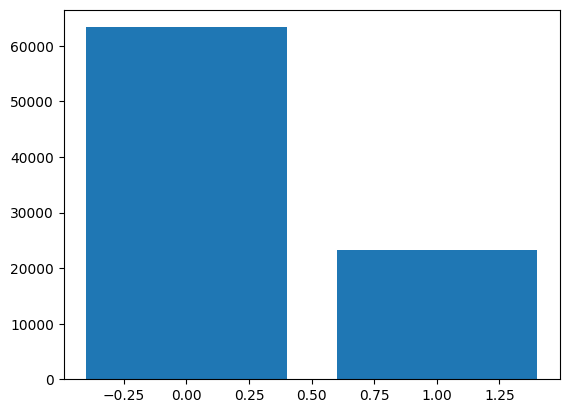

In [17]:
plt.bar(x = [0,1],height = [count_canceled.values[0],count_canceled.values[1]])

##### Видим, что значения метки не сбалансированны, сделаем балансировку

#### Будем использовать метод SMOTE для балансировки

In [18]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = sm.fit_resample(X, y)

In [20]:
from sklearn.model_selection import train_test_split

#тестовые и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(
X_res, y_res, test_size=0.2)

#### Будем обучать с помощью RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

#### Проверяем качество собственной модели с помощью метрик f1-score и roc_auc_score

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(f"Оценка качества модели по метрике F1-score: {f1_score(y_test, rf.predict(X_test))}")
print(f"Оценка качества модели по метрике ROC AUC: {roc_auc_score(y_test, rf.predict(X_test))}")

Оценка качества модели по метрике F1-score: 0.8532792427315753
Оценка качества модели по метрике ROC AUC: 0.8544522544889237


#### Confusion matrix 

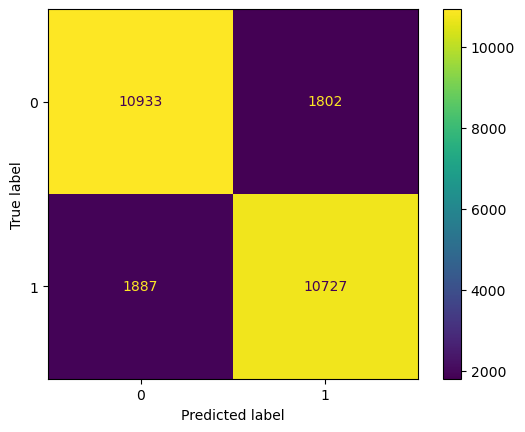

In [19]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, rf.predict(X_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

#### ROC-Curve

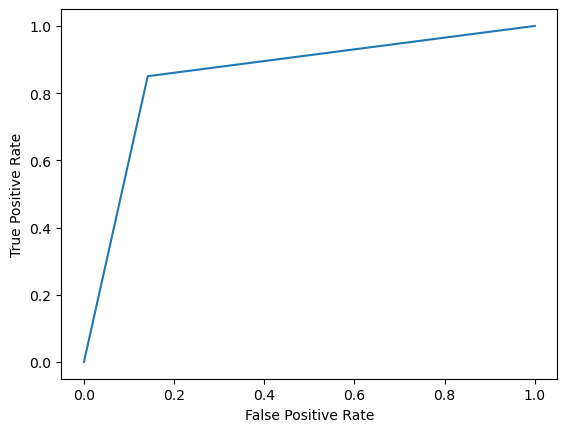

In [20]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(y_test, rf.predict(X_test))